# Analysing the solution space

The creation of an algorithm that generates all feasible solutions with equal probability enabled us to explore and analyse the distribution of costs. We created this to analyse a given dataset.

In [237]:
from paintshop import PaintShop, Source
from solution_space import get_solution_space_size

# Load dataset
# PS = PaintShop(Source.SEPTEMBER)
PS = PaintShop(Source.NOVEMBER)

Loaded 'resources\PaintShop - November 2024.xlsx'


We first import the datasets and calculate the size of the respective solution spaces

In [238]:
print(f'{PS.source_id}:')
print(f"|O|: {PS.order_count}")
print(f"|M|: {PS.machine_count}")
print(f"|S|: {get_solution_space_size(PS):.0e} ({get_solution_space_size(PS)})")

NOVEMBER:
|O|: 46
|M|: 4
|S|: 5e+27 (4951760157141521099596496896)


Lets test if we can generate a random solution. Go ahead, run it a few times.

In [239]:
from heuristics_constructive import Random

generator = Random(PS)

In [240]:
print(generator.get_schedule())

    |  0   1   2   3   4   5   6   7   8   9  10  11  12  13  | 10906.24 ✔
M1: |  1   5  14  19  21  22  27  33  34  35  37  40  42      | 2960.50 (27%)
M2: |  3   6   9  11  15  17  18  23  25  29  30  39  43  44  | 2855.50 (26%)
M3: |  8  10  26  31  36  38  41                              | 313.82  (3%)
M4: |  0   2   4   7  12  13  16  20  24  28  32  45          | 4776.41 (44%)


Now lets generate a sample of costs from the solution space.

In [241]:
import os
import pickle
from time import time

target_sample_size = 1000000
sample_batch_size  = 1000

# Ensure chache folder exists
cache_folder = os.path.join('cache', 'solution_space_cost_samples')
if not os.path.exists(cache_folder):
    os.mkdir(cache_folder)
    
# Set cache file path
cache_file_path = os.path.join(cache_folder, f'{PS.source_id}.pickle')

# Load existing sample if exists
samples = []
if os.path.exists(cache_file_path):
    with open(cache_file_path,'rb') as file:
        cached_samples = pickle.load(file)
    print(f"Loaded {len(cached_samples)} samples from '{cache_file_path}'.")
    samples += cached_samples

# Create the rest of the samples if needed
missing_sample_count = target_sample_size - len(samples)
if missing_sample_count > 0:
    
    # Generate missing samples
    while len(samples) < target_sample_size:
        
        samples_to_generate = min(sample_batch_size, missing_sample_count)
        
        t0 = time()
        samples += [generator.get_schedule().cost for _ in range(samples_to_generate)]
        print(f"{len(samples)} | {time() - t0:.2f}s")
    
    # Save samples
    with open(cache_file_path, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(samples, outp, pickle.HIGHEST_PROTOCOL)
    print(f"Saved: '{cache_file_path}'")

Loaded 100000 samples from 'cache\solution_space_cost_samples\NOVEMBER.pickle'.
101000 | 1.02s
102000 | 1.01s
103000 | 1.03s
104000 | 1.05s
105000 | 1.07s
106000 | 1.06s
107000 | 1.07s
108000 | 1.10s
109000 | 1.06s
110000 | 1.08s
111000 | 1.12s
112000 | 1.08s
113000 | 1.10s
114000 | 1.14s
115000 | 1.18s
116000 | 1.19s
117000 | 1.23s
118000 | 1.27s
119000 | 1.26s
120000 | 1.25s
121000 | 1.23s
122000 | 1.17s
123000 | 1.26s
124000 | 1.18s
125000 | 1.20s
126000 | 1.22s
127000 | 1.22s
128000 | 1.20s
129000 | 1.22s
130000 | 1.17s
131000 | 1.17s
132000 | 1.18s
133000 | 1.21s
134000 | 1.22s
135000 | 1.22s
136000 | 1.23s
137000 | 1.34s
138000 | 1.31s
139000 | 1.21s
140000 | 1.20s
141000 | 1.16s
142000 | 1.16s
143000 | 1.20s
144000 | 1.22s
145000 | 1.17s
146000 | 1.14s
147000 | 1.15s
148000 | 1.17s
149000 | 1.21s
150000 | 1.20s
151000 | 1.21s
152000 | 1.16s
153000 | 1.17s
154000 | 1.13s
155000 | 1.14s
156000 | 1.15s
157000 | 1.16s
158000 | 1.11s
159000 | 1.09s
160000 | 1.09s
161000 | 1.14s
16200

First, we'll plot the distribution of costs.

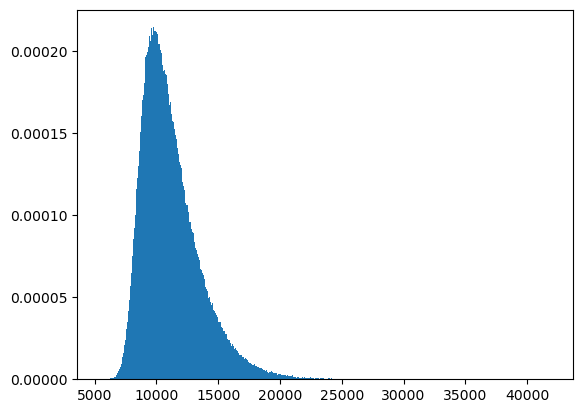

In [247]:
import matplotlib.pyplot as plt
plt.hist(samples, bins = 1000, density = True)
plt.show()

### Interestingly, settings the x-axis to log makes it look more like a normal-distribution

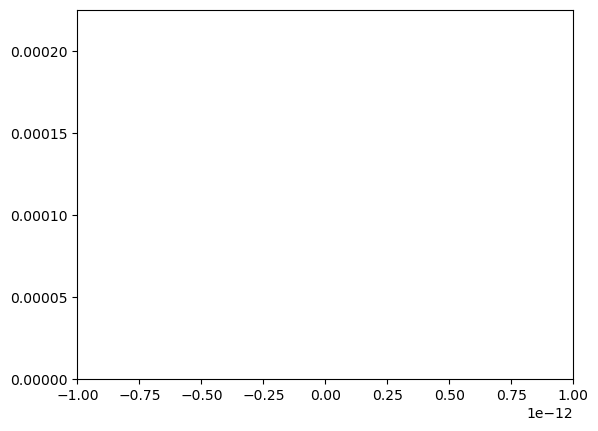

In [250]:
from functools import partial
from math import exp
import matplotlib.pyplot as plt
import numpy as np

plt.hist(samples, bins = 1000, density = True)
plt.gca().set_xscale('function', functions=(lambda x: exp(x)))
plt.show()

# Looks a bit like an f-distribution!
### Lets fit one!

In [243]:
import numpy as np
import scipy.stats as stats

shape_a, shape_b, loc, scale = stats.f.fit(samples)
print(shape_a, shape_b, loc, scale)

3070.7770887785646 53.56290105754515 -43.411158755488756 10804.739345913591


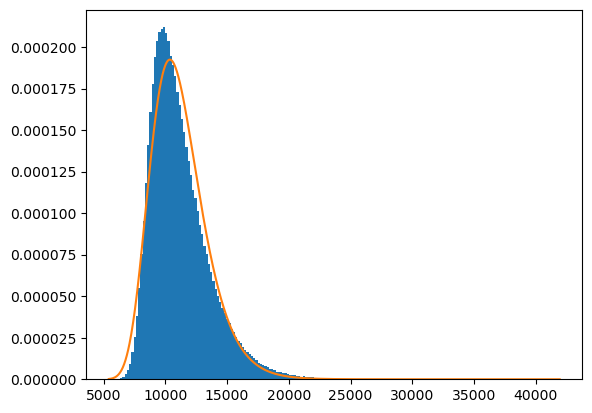

In [244]:
xs = np.linspace(min(samples), max(samples), 1000)
plt.hist(samples, bins = 200, density = True)
plt.plot(xs, stats.f.pdf(xs, shape_a, shape_b, loc = loc, scale = scale))
plt.show()

### Since that didn't work, lets try a whole set of fits to see which one works the best.

In [245]:
from distfit import distfit

# Initialize distfit
dist = distfit(boots = 10)

# Determine best-fitting probability distribution for data
dist.fit_transform(np.array(samples))

TypeError: distfit.__init__() got an unexpected keyword argument 'boots'

[distfit] >INFO> Ploting Summary.
[distfit] >INFO> Bootstrap results are included..


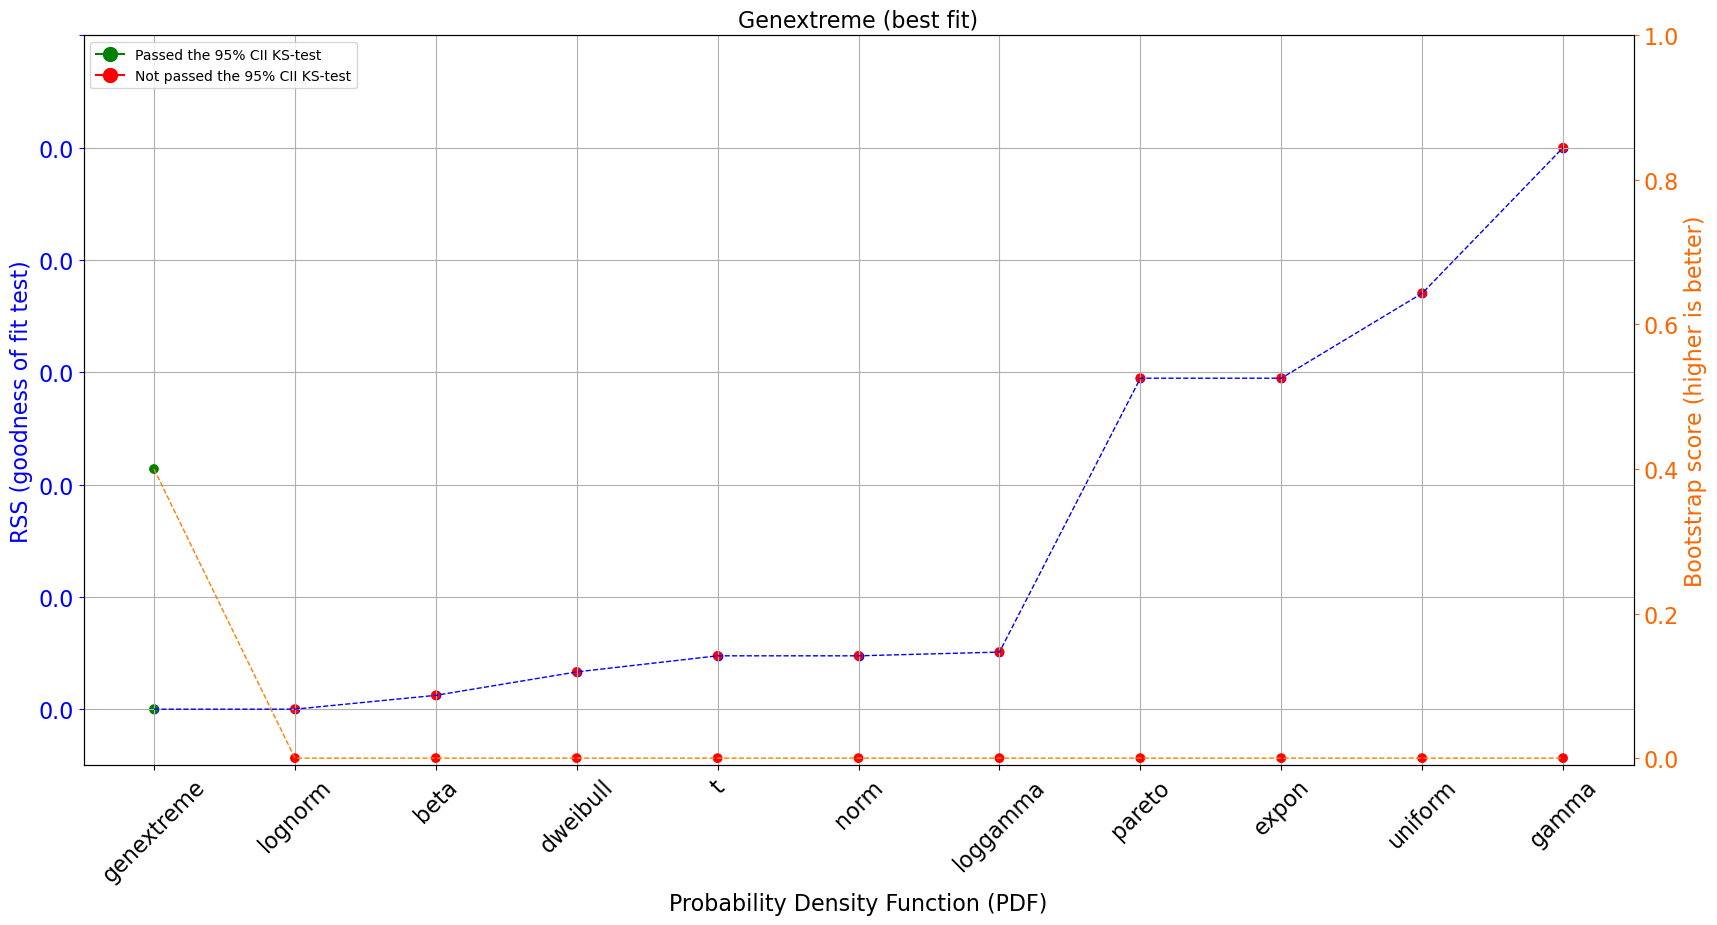

In [197]:
dist.plot_summary()
plt.show()

[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Genextreme(loc:10071.639826, scale:1746.954678)


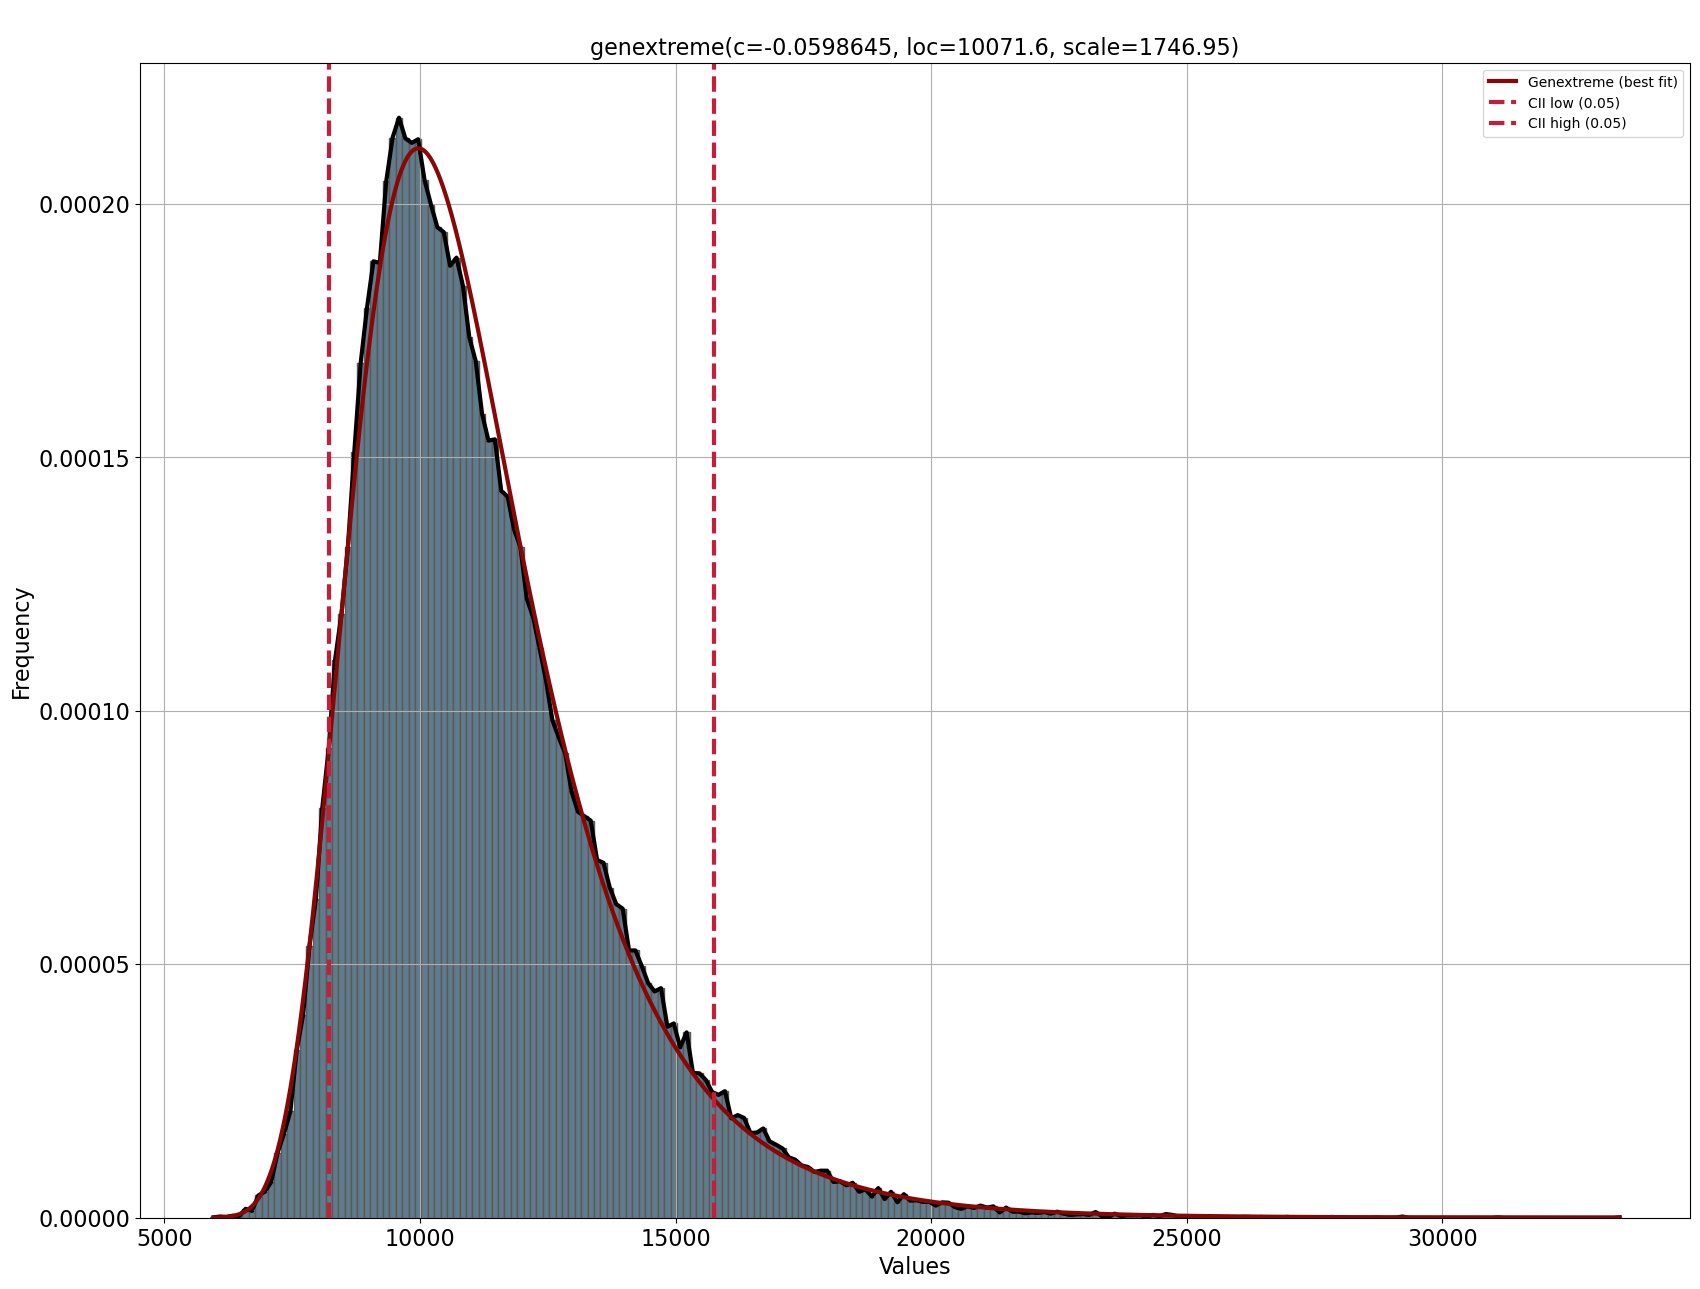

In [198]:
dist.plot()
plt.show()

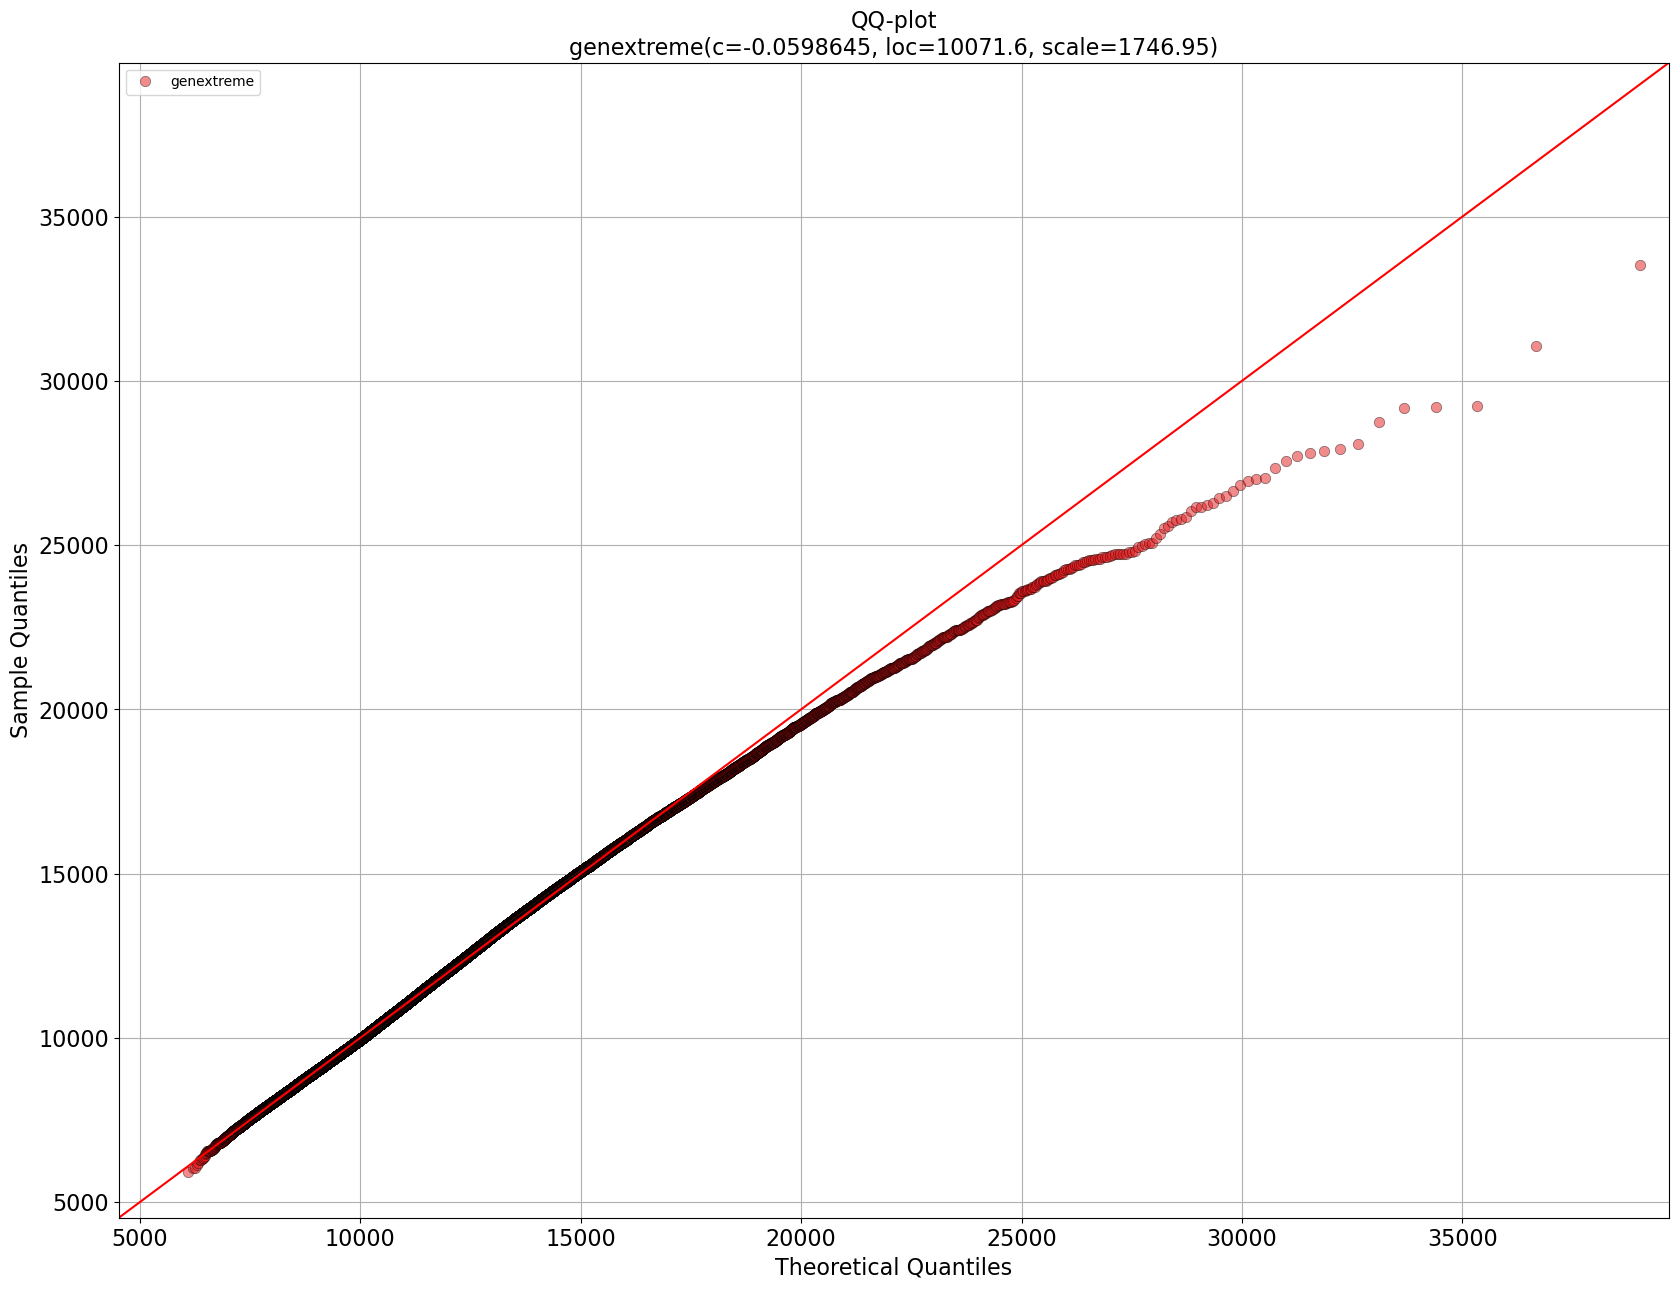

In [199]:
dist.qqplot(np.array(samples))
plt.show()

### Now lets use that to create a scipy.stats model

In [207]:
params = dist.model["params"]
params

(-0.05986446921168154, 10071.639825535185, 1746.9546775015517)

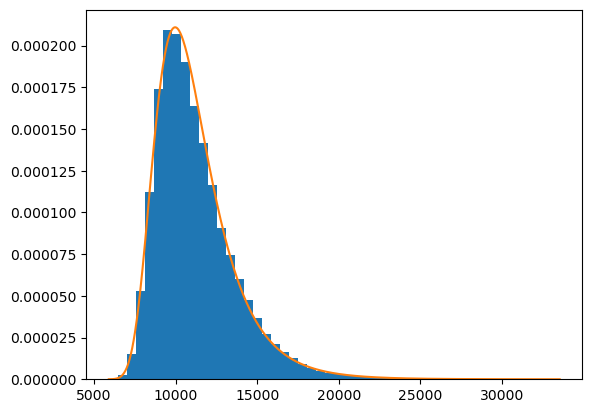

In [209]:
model = stats.genextreme

plt.hist(samples, bins = 50, density = True)
plt.plot(xs, model.pdf(xs, *params))
plt.show()

In [233]:
# Chance of getting a solution under 100:
cost = 10000
while model.cdf(cost, *params) > 0:
    print(f"{(str(cost) + ':'):<7} | {model.cdf(cost, *params):<10.2e} | {model.cdf(cost, *params) * get_solution_space_size(PS):.2e}")
    cost -= 100

10000:  | 3.53e-01   | 1.75e+27
9900:   | 3.32e-01   | 1.64e+27
9800:   | 3.11e-01   | 1.54e+27
9700:   | 2.90e-01   | 1.43e+27
9600:   | 2.69e-01   | 1.33e+27
9500:   | 2.49e-01   | 1.23e+27
9400:   | 2.29e-01   | 1.13e+27
9300:   | 2.09e-01   | 1.04e+27
9200:   | 1.90e-01   | 9.42e+26
9100:   | 1.72e-01   | 8.51e+26
9000:   | 1.54e-01   | 7.65e+26
8900:   | 1.38e-01   | 6.82e+26
8800:   | 1.22e-01   | 6.03e+26
8700:   | 1.07e-01   | 5.30e+26
8600:   | 9.31e-02   | 4.61e+26
8500:   | 8.04e-02   | 3.98e+26
8400:   | 6.86e-02   | 3.40e+26
8300:   | 5.80e-02   | 2.87e+26
8200:   | 4.85e-02   | 2.40e+26
8100:   | 4.01e-02   | 1.98e+26
8000:   | 3.27e-02   | 1.62e+26
7900:   | 2.63e-02   | 1.30e+26
7800:   | 2.08e-02   | 1.03e+26
7700:   | 1.62e-02   | 8.04e+25
7600:   | 1.25e-02   | 6.17e+25
7500:   | 9.38e-03   | 4.64e+25
7400:   | 6.93e-03   | 3.43e+25
7300:   | 5.01e-03   | 2.48e+25
7200:   | 3.54e-03   | 1.75e+25
7100:   | 2.45e-03   | 1.21e+25
7000:   | 1.64e-03   | 8.15e+24
6900:   

In [235]:
# Number of estimated solutions with 0 cost:
get_solution_space_size(PS) * model.cdf(0, *params)

0.0

In [236]:
# Best estimate for lowest cost solution
model.ppf(1/get_solution_space_size(PS), *params)

3644.991778885719